In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm
import collections

In [203]:
v10_cb = pd.read_csv("v10_cb.csv")
v10_p4 = pd.read_csv("v10_p4.csv")

v10_cb["timestamp"]= v10_cb["timestamp"].apply(lambda x: datetime.fromtimestamp(x/1000))
v10_p4["timestamp"]= v10_p4["timestamp"].apply(lambda x: datetime.fromtimestamp(x/1000))

v10_cb["timestamp"]= v10_cb["timestamp"].apply(lambda x: x - v10_cb["timestamp"][0])
v10_p4["timestamp"]= v10_p4["timestamp"].apply(lambda x: x - v10_p4["timestamp"][0])

v10_cb["timestamp"] = v10_cb["timestamp"].dt.seconds + v10_cb["timestamp"].dt.microseconds/10e6
v10_p4["timestamp"] = v10_p4["timestamp"].dt.seconds + v10_p4["timestamp"].dt.microseconds/10e6

In [204]:
dt_cb = v10_cb["timestamp"]
dt_p4 = v10_p4["timestamp"]

cb = v10_cb["val"]
p4 = v10_p4["val"]

In [205]:
np.min(cb)

0.280737

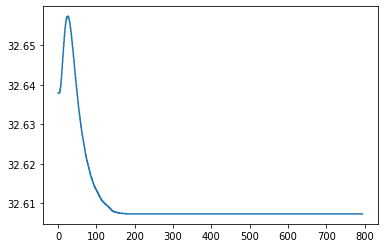

In [206]:
plt.plot(dt_p4,p4)
plt.show()

In [207]:
epochs = 50000
optimizer = tf.keras.optimizers.SGD(learning_rate=10e-2, momentum= 0.95)
# t0 = tf.Variable(tf.random.uniform((1,),minval=-100, maxval=100, name='t0'))
# t1 = tf.Variable(tf.random.uniform((1,),minval=0, maxval=100, name='t1'))
# t2 = tf.Variable(tf.random.uniform((1,),minval=0, maxval=100, name='t2'))

t0 = tf.Variable(0.0, name='t0')
t1 = tf.Variable(1.0, name='t1', constraint = lambda z: tf.clip_by_value(z, 0.0, 100.0))
t2 = tf.Variable(2.0, name='t2', constraint = lambda z: tf.clip_by_value(z, 0.0, 100.0))

loss_metric = tf.keras.metrics.Mean()

def loss_compute(y_true, y_pred):
    return tf.square(y_true - y_pred)

patience = 20
delta = 1
loss_history = collections.deque(maxlen=patience + 1)

# print(t0)
# print(t1)
# print(t2)
# print(" ")

for epoch in range(epochs):
    # pbar = tqdm(range(len(p4)))
    loss = 0
    # for batch_id in pbar:
    time = tf.constant(dt_p4,dtype=tf.float32)
    y = tf.constant(p4,dtype = tf.float32)

    with tf.GradientTape(persistent=True) as tape:
        # y = A+B*(1+C*e**(-t/D)+E*e**(-t/F))
        e1 = tf.exp(-time/t1)
        e2 = tf.exp(-time/t2)
        c1 = tf.divide(tf.subtract(t0,t1),tf.add(tf.subtract(t1,t2),tf.constant(10e-3)))
        c2 = tf.divide(tf.subtract(t0,t2),tf.add(tf.subtract(t2,t1),tf.constant(10e-3)))
        h1 = tf.multiply(c1,tf.cast(e1, tf.float32))
        h2 = tf.multiply(c2,tf.cast(e2, tf.float32))
        h = 1 + h1 + h2
        y_ = p4[0]+tf.multiply(p4[-1:]-p4[0],h)
        loss1 = loss_compute(y, y_)
        loss = tf.reduce_sum(loss1)

        print(epoch, "  ", loss)
        loss_history.append(loss)

        if tf.math.is_nan(c1):
            raise Exception("NaN")
        
        # print(e1," , ", e2," , ",c1," , ",c2," , ",h1," , ",h2)
        # loss_metric(loss)
        # pbar.set_description('Training Loss: %.3f' % 
        #                         loss_metric.result().numpy())

    gradients = tape.gradient(loss,[t0,t1, t2])
    optimizer.apply_gradients(zip(gradients, [t0,t1,t2]))

    if len(loss_history) > patience:
        if loss_history.popleft()*delta < min(loss_history):
            print(f'\nEarly stopping. No improvement of more than {delta:.5%} in '
                  f'validation loss in the last {patience} epochs.')
            break
    # print(gradients)
    # print(" ")
    # print(t0)
    # print(t1)
    # print(t2)
    # print(" ")

0    tf.Tensor(0.87803626, shape=(), dtype=float32)
1    tf.Tensor(0.87799954, shape=(), dtype=float32)
2    tf.Tensor(0.8779298, shape=(), dtype=float32)
3    tf.Tensor(0.8778262, shape=(), dtype=float32)
4    tf.Tensor(0.87769055, shape=(), dtype=float32)
5    tf.Tensor(0.87752247, shape=(), dtype=float32)
6    tf.Tensor(0.87732697, shape=(), dtype=float32)
7    tf.Tensor(0.8771066, shape=(), dtype=float32)
8    tf.Tensor(0.87685895, shape=(), dtype=float32)
9    tf.Tensor(0.8765904, shape=(), dtype=float32)
10    tf.Tensor(0.8762956, shape=(), dtype=float32)
11    tf.Tensor(0.8759787, shape=(), dtype=float32)
12    tf.Tensor(0.87564063, shape=(), dtype=float32)
13    tf.Tensor(0.87527895, shape=(), dtype=float32)
14    tf.Tensor(0.87489957, shape=(), dtype=float32)
15    tf.Tensor(0.8745016, shape=(), dtype=float32)
16    tf.Tensor(0.8740918, shape=(), dtype=float32)
17    tf.Tensor(0.87365925, shape=(), dtype=float32)
18    tf.Tensor(0.87321043, shape=(), dtype=float32)
19    tf.Te

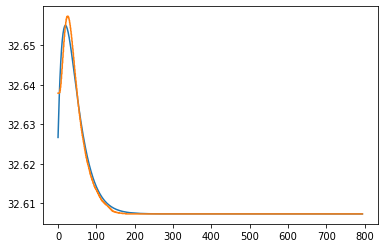

In [208]:
e1 = tf.exp(-dt_p4/t1)
e2 = tf.exp(-dt_p4/t2)
c1 = tf.divide(tf.subtract(t0,t1),tf.add(tf.subtract(t1,t2),tf.constant(10e-3)))
c2 = tf.divide(tf.subtract(t0,t2),tf.add(tf.subtract(t2,t1),tf.constant(10e-3)))
h1 = tf.multiply(c1,tf.cast(e1, tf.float32))
h2 = tf.multiply(c2,tf.cast(e2, tf.float32))
h = 1 + h1 + h2
y_ = p4[0]+tf.multiply(p4[-1:]-p4[0],h)
plt.plot(dt_p4,y_)
plt.plot(dt_p4,p4)
plt.show()

In [209]:
print(t0)
print(t1)
print(t2)
print(loss)

<tf.Variable 't0:0' shape=() dtype=float32, numpy=-60.06857>
<tf.Variable 't1:0' shape=() dtype=float32, numpy=22.492022>
<tf.Variable 't2:0' shape=() dtype=float32, numpy=24.627726>
tf.Tensor(0.009129043, shape=(), dtype=float32)


In [210]:
epochs = 50000
optimizer = tf.keras.optimizers.SGD(learning_rate=10e-2, momentum= 0.95)
# t0 = tf.Variable(tf.random.uniform((1,),minval=-100, maxval=100, name='t0'))
# t1 = tf.Variable(tf.random.uniform((1,),minval=0, maxval=100, name='t1'))
# t2 = tf.Variable(tf.random.uniform((1,),minval=0, maxval=100, name='t2'))

ta = tf.Variable(0.0, name='t0')
tb = tf.Variable(0.0, name='t0')
t1 = tf.Variable(1.0, name='t1', constraint = lambda z: tf.clip_by_value(z, 0.0, 100.0))
t2 = tf.Variable(2.0, name='t2', constraint = lambda z: tf.clip_by_value(z, 0.0, 100.0))
t3 = tf.Variable(2.0, name='t2', constraint = lambda z: tf.clip_by_value(z, 0.0, 100.0))

loss_metric = tf.keras.metrics.Mean()

def loss_compute(y_true, y_pred):
    return tf.square(y_true - y_pred)

patience = 20
delta = 1
loss_history = collections.deque(maxlen=patience + 1)

# print(t0)
# print(t1)
# print(t2)
# print(" ")

for epoch in range(epochs):
    # pbar = tqdm(range(len(p4)))
    loss = 0
    # for batch_id in pbar:
    time = tf.constant(dt_cb,dtype=tf.float32)
    y = tf.constant(cb,dtype = tf.float32)

    with tf.GradientTape(persistent=True) as tape:
        # y = A+B*(1+C*e**(-t/D)+E*e**(-t/F))
        e1 = np.exp(-time/t1)
        e2 = np.exp(-time/t2)
        e3 = np.exp(-time/t2)
        c1 = tf.divide(tf.subtract(t0,t1),tf.add(tf.subtract(t1,t2),tf.constant(10e-3)))
        c2 = tf.divide(tf.subtract(t0,t2),tf.add(tf.subtract(t2,t1),tf.constant(10e-3)))
        h1 = tf.multiply(c1,tf.cast(e1, tf.float32))
        h2 = tf.multiply(c2,tf.cast(e2, tf.float32))
        h = 1 + h1 + h2
        y_ = cb[0]+tf.multiply(cb[-1:]-cb[0],h)
        loss1 = loss_compute(y, y_)
        loss = tf.reduce_sum(loss1)

        print(epoch, "  ", loss)
        loss_history.append(loss)

        if tf.math.is_nan(c1):
            raise Exception("NaN")
        
        # print(e1," , ", e2," , ",c1," , ",c2," , ",h1," , ",h2)
        # loss_metric(loss)
        # pbar.set_description('Training Loss: %.3f' % 
        #                         loss_metric.result().numpy())

    gradients = tape.gradient(loss,[t0,t1, t2])
    optimizer.apply_gradients(zip(gradients, [t0,t1,t2]))

    if len(loss_history) > patience:
        if loss_history.popleft()*delta < min(loss_history):
            print(f'\nEarly stopping. No improvement of more than {delta:.5%} in '
                  f'validation loss in the last {patience} epochs.')
            break
    # print(gradients)
    # print(" ")
    # print(t0)
    # print(t1)
    # print(t2)
    # print(" ")

0    tf.Tensor(2.7636954e-05, shape=(), dtype=float32)
1    tf.Tensor(2.7636912e-05, shape=(), dtype=float32)
2    tf.Tensor(2.7636946e-05, shape=(), dtype=float32)
3    tf.Tensor(2.7637072e-05, shape=(), dtype=float32)
4    tf.Tensor(2.763712e-05, shape=(), dtype=float32)
5    tf.Tensor(2.7637101e-05, shape=(), dtype=float32)
6    tf.Tensor(2.7637323e-05, shape=(), dtype=float32)
7    tf.Tensor(2.7637407e-05, shape=(), dtype=float32)
8    tf.Tensor(2.7637607e-05, shape=(), dtype=float32)
9    tf.Tensor(2.7637645e-05, shape=(), dtype=float32)
10    tf.Tensor(2.7637709e-05, shape=(), dtype=float32)
11    tf.Tensor(2.7637836e-05, shape=(), dtype=float32)
12    tf.Tensor(2.763792e-05, shape=(), dtype=float32)
13    tf.Tensor(2.7638243e-05, shape=(), dtype=float32)
14    tf.Tensor(2.7638407e-05, shape=(), dtype=float32)
15    tf.Tensor(2.7638622e-05, shape=(), dtype=float32)
16    tf.Tensor(2.7638655e-05, shape=(), dtype=float32)
17    tf.Tensor(2.7639091e-05, shape=(), dtype=float32)
18  

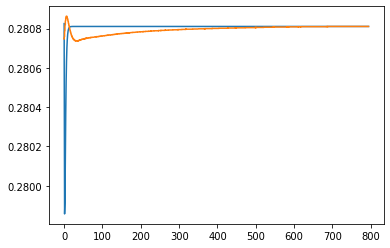

In [213]:
e1 = tf.exp(-dt_cb/t1)
e2 = tf.exp(-dt_cb/t2)
c1 = tf.divide(tf.subtract(t0,t1),tf.add(tf.subtract(t1,t2),tf.constant(10e-3)))
c2 = tf.divide(tf.subtract(t0,t2),tf.add(tf.subtract(t2,t1),tf.constant(10e-3)))
h1 = tf.multiply(c1,tf.cast(e1, tf.float32))
h2 = tf.multiply(c2,tf.cast(e2, tf.float32))
h = 1 + h1 + h2
y_ = cb[0]+tf.multiply(cb[-1:]-cb[0],h)
plt.plot(dt_cb,y_)
plt.plot(dt_cb,cb)
plt.show()

In [212]:
print(t0)
print(t1)
print(t2)
print(loss)

<tf.Variable 't0:0' shape=() dtype=float32, numpy=-60.06857>
<tf.Variable 't1:0' shape=() dtype=float32, numpy=0.999201>
<tf.Variable 't2:0' shape=() dtype=float32, numpy=2.0007858>
tf.Tensor(2.763987e-05, shape=(), dtype=float32)
